In [1]:
from landmark_detection.pipeline import Pipeline_Landmark_Detection
from landmark_detection.utils import show_image, show_bboxes, show_similarity_search

import os
import pandas as pd
import pickle
import numpy as np

In [2]:
DATASETS_PATH = os.path.abspath("datasets")

CACERES_CSV = os.path.join(DATASETS_PATH, "caceres", "caceres_dataset.csv")
CACERES_DF = os.path.join(DATASETS_PATH, "caceres", "results", "df_caceres-v1.pkl")
CACERES_DESC = os.path.join(DATASETS_PATH, "caceres", "results", "desc_caceres-v1.pkl")

TEST_PLACES_DB = os.path.join("landmark_detection", "test_data", "test_places_db.pkl")

caceres_csv = pd.read_csv(CACERES_CSV)

with open(CACERES_DF, 'rb') as f:
    caceres_df = pickle.load(f)

with open(CACERES_DESC, 'rb') as f:
    caceres_desc = pickle.load(f)

# Crear columna sin extensión en df_result_cac
caceres_df["filename"] = caceres_df["image_name"].str.replace(".jpg", "", regex=False)

# Hacer el merge con caceres_dataset para obtener el landmark_id
df_merged = caceres_df.merge(caceres_csv[["filename", "landmark_id"]], on="filename", how="left")

# Obtener el tensor de landmark_id
places_id = df_merged["landmark_id"].values

caceres_desc_ids = np.concatenate((caceres_desc, places_id[:, None]), axis=1)

with open(TEST_PLACES_DB, 'wb') as f:
    pickle.dump(caceres_desc_ids, f)

In [3]:
pipeline = Pipeline_Landmark_Detection(
        detector_file = "yolov8n-oiv7.pt",
        extractor_onnx_file = "cvnet-sg-v1.onnx",
        pipeline_onnx_file = "pipeline-yolo-cvnet-sg-v1.onnx",
        image_dim = (640, 640),
        allowed_classes = [41,68,70,74,87,95,113,144,150,158,164,165,193,205,212,224,257,
                                      298,310,335,351,354,390,393,401,403,439,442,457,466,489,510,512,
                                      514,524,530,531,543,546,554,565,573,580,587,588,591],
        score_thresh = 0.05,
        iou_thresh = 0.25,
        scales = [0.7071, 1.0, 1.4142],
        mean = [0.485, 0.456, 0.406],
        std  = [0.229, 0.224, 0.225],
        rgem_pr = 2.5,
        rgem_size = 5,
        gem_p = 4.6,
        sgem_ps = 10.0,
        sgem_infinity = False,
        eps = 1e-8,
        topk = 5,
        min_sim = 0.8,
        min_votes = 0.55,
        remove_inner_boxes = 0.85,
        join_boxes = True
)

Creando versión ONNX del preprocess
Instanciando el preprocessor
Creando versión ONNX del detector


C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\preprocess.py:13: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  h = torch.tensor(img_bgr.shape[0], dtype=torch.float32)
C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\preprocess.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h = torch.tensor(img_bgr.shape[0], dtype=torch.float32)
C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\preprocess.py:14: TracerWarning: torch.tensor results are registered as constants in the trace

Ultralytics 8.3.146  Python-3.11.11 torch-2.7.0+cpu CPU (Intel Core(TM) i5-9300HF 2.40GHz)
YOLOv8n summary (fused): 72 layers, 3,492,527 parameters, 0 gradients, 10.5 GFLOPs

PyTorch: starting from 'C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models\yolov8n-oiv7.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 605, 8400) (6.9 MB)

ONNX: starting export with onnx 1.17.0 opset 16...
ONNX: slimming with onnxslim 0.1.54...
ONNX: export success  1.4s, saved as 'C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models\yolov8n-oiv7.onnx' (13.5 MB)

Export complete (1.9s)
Results saved to C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models
Predict:         yolo predict task=detect model=C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models\yolov8n-oiv7.onnx imgsz=640  
Validate:        yolo val task=detect model=C:\Users\rdi

In [4]:
TEST_IMG_PATH = os.path.join("test_images", "caceres.jpg")
TEST_PLACES_DB = os.path.join("landmark_detection", "test_data", "test_places_db.pkl")
DATASETS_PATH = os.path.abspath("datasets")
CACERES_LANDMARK_NAMES_PATH = os.path.join(DATASETS_PATH, "caceres", "caceres_landmarks.yaml")

with open(TEST_PLACES_DB, 'rb') as f:
    places_db = pickle.load(f)

In [5]:
image_proc, orig_size, places_db = pipeline.preprocess(TEST_IMG_PATH, places_db)

print('image_proc.shape: ', image_proc.shape)
print('orig_size:', orig_size)
print('places_db.shape:', places_db.shape)

image_proc.shape:  (1, 3, 640, 640)
orig_size: [       2500        1663]
places_db.shape: (271, 2049)


In [6]:
detections, image_proc, places_db, orig_size = pipeline.detect(image_proc, places_db, orig_size)

print('detections[0].shape: ', detections[0].shape)
print('image_proc.shape: ', image_proc.shape)
print('places_db.shape:', places_db.shape)
print('orig_size:', orig_size)

detections[0].shape:  (605, 8400)
image_proc.shape:  (1, 3, 640, 640)
places_db.shape: (271, 2049)
orig_size: [       2500        1663]


In [7]:
boxes, descriptors, places_db, orig_size = pipeline.extract(detections, image_proc, places_db, orig_size)

print('boxes.shape: ', boxes.shape)
print('descriptors.shape: ', descriptors.shape)
print('places_db.shape:', places_db.shape)
print('orig_size:', orig_size)

boxes.shape:  (16, 4)
descriptors.shape:  (16, 2048)
places_db.shape: (271, 2049)
orig_size: [       2500        1663]


In [8]:
boxes_out, scores_out, classes_out, orig_size = pipeline.search(boxes, descriptors, places_db, orig_size)

print('boxes_out.shape: ', boxes_out.shape)
print('scores_out.shape: ', scores_out.shape)
print('classes_out.shape:', classes_out.shape)
print('orig_size:', orig_size)

boxes_out.shape:  (21, 4)
scores_out.shape:  (21,)
classes_out.shape: (21,)
orig_size: [       2500        1663]


In [11]:
scaled_boxes, final_scores, final_classes = pipeline.postprocess(boxes_out, scores_out, classes_out, orig_size)

print('scaled_boxes.shape: ', scaled_boxes.shape)
print('final_scores.shape: ', final_scores.shape)
print('final_classes.shape:', final_classes.shape)

scaled_boxes.shape:  (21, 4)
final_scores.shape:  (21,)
final_classes.shape: (21,)


In [12]:
pipeline_boxes, pipeline_scores, pipelinel_classes = pipeline.run(TEST_IMG_PATH, places_db)

print('final_boxes.shape: ', final_boxes.shape)
print('final_scores.shape: ', final_scores.shape)
print('final_classes.shape:', final_classes.shape)

final_boxes.shape:  (21, 4)
final_scores.shape:  (21,)
final_classes.shape: (21,)


Encontradas 21 cajas:
  Clase 0 Arco de la Estrella @ -inf → [inf,inf,-inf,-inf]
  Clase 1 Torre de Bujaco @ 0.80 → [1526.0,567.3,1941.0,793.8]
  Clase 2 Concatedral de Santa María @ -inf → [inf,inf,-inf,-inf]
  Clase 3 Palacio de los Golfines de Abajo @ -inf → [inf,inf,-inf,-inf]
  Clase 4 Palacio de Carvajal @ -inf → [inf,inf,-inf,-inf]
  Clase 5 Casa de las Veletas @ -inf → [inf,inf,-inf,-inf]
  Clase 6 Iglesia de San Francisco Javier @ 0.80 → [1161.7,437.6,1352.9,1029.0]
  Clase -1 full image @ 0.00 → [0.0,0.0,2496.1,1660.4]
  Clase -1 full image @ 0.00 → [26.2,423.6,2498.2,1661.6]
  Clase -1 full image @ 0.00 → [1108.0,1478.9,1185.4,1544.8]
  Clase -1 full image @ 0.00 → [1839.6,496.5,1953.1,714.2]
  Clase -1 full image @ 0.00 → [1401.0,1370.5,1454.4,1420.6]
  Clase -1 full image @ 0.00 → [1285.2,1495.5,1375.8,1608.3]
  Clase -1 full image @ 0.00 → [2017.4,994.5,2452.8,1297.8]
  Clase -1 full image @ 0.00 → [1992.1,594.7,2160.0,746.6]
  Clase -1 full image @ 0.00 → [941.0,1621.4,1

C:\ProgramData\anaconda3\envs\tfm_yolo\Lib\site-packages\matplotlib\patches.py:796: RuntimeWarning: invalid value encountered in scalar add
  x1 = self.convert_xunits(self._x0 + self._width)
C:\ProgramData\anaconda3\envs\tfm_yolo\Lib\site-packages\matplotlib\patches.py:797: RuntimeWarning: invalid value encountered in scalar add
  y1 = self.convert_yunits(self._y0 + self._height)


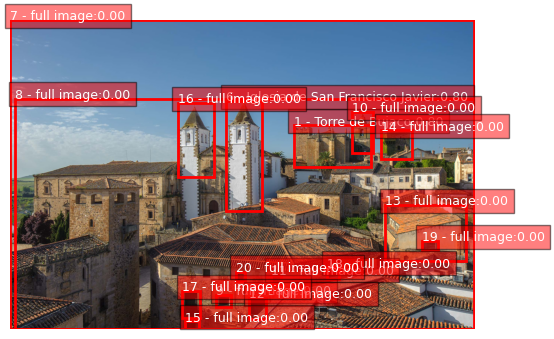

In [18]:
show_bboxes(TEST_IMG_PATH, CACERES_LANDMARK_NAMES_PATH, pipeline_boxes, pipelinel_classes, pipeline_scores)